In [1]:
import numpy as np
from numpy.lib import recfunctions as rf
from pathlib import Path
import fitsio
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import galsim as gs
import astropy.units as u
from astropy.table import Table, vstack
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
import pdb

In [2]:
#id_tag = self.config['input']['id_tag']
#ra_tag = self.config['input']['ra_tag']
#dec_tag = self.config['input']['dec_tag']
ra_tag = 'ALPHAWIN_J2000'
dec_tag = 'DELTAWIN_J2000'

ra_unit = u.Unit('deg')
dec_unit = u.Unit('deg')

0.19993176
(35, 35)


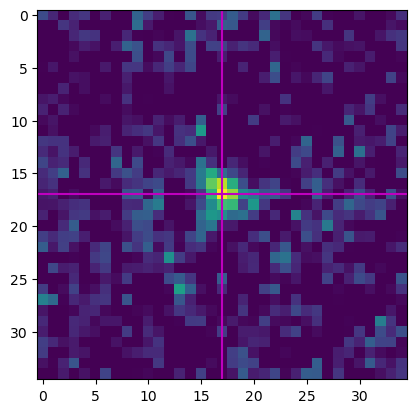

In [3]:
workdir = '/Users/j.mccleary/Research/jwst_cosmos/real_data/working2'
catalog_name = 'mosaic_nircam_f115w_COSMOS-Web_30mas_v0_1_starcat.fits'
catalog = os.path.join(workdir, catalog_name)

starcat = Table.read(catalog, hdu=2)
obj = starcat[212]
vignet_size = np.shape(obj['VIGNET'])[0]
plt.figure()
plt.imshow(obj['VIGNET'], vmin=-0.005, vmax=0.2)
plt.axvline((vignet_size-1)/2, ls='-', color='m')
plt.axhline((vignet_size-1)/2, ls='-', color='m')

print(np.max(obj['VIGNET']))
print(np.shape(obj['VIGNET']))


In [4]:
coord = SkyCoord(
    ra=obj[ra_tag]*ra_unit, dec=obj[dec_tag]*dec_unit
    )

print(coord)

<SkyCoord (ICRS): (ra, dec) in deg
    (149.94369189, 2.32615811)>


In [5]:
imdir = '/Users/j.mccleary/Research/jwst_cosmos/real_data/'
im_name = 'mosaic_nircam_f115w_COSMOS-Web_30mas_v0_1_sci.fits'
imfile = os.path.join(imdir, im_name)

# OK, so in cookie cutter, image is a fitsio.FITS object and specifically the first extension! 
# imfile = fitsio.FITS('mosaic_nircam_f150w_COSMOS-Web_30mas_v0_1_sci.fits', 'r')[0]
# image array is f.read()

# default behavior is to grab it from the passed image header
# For whatever reason, with the way the COSMOS-Web coadds are, astropy.io.fits
# works better than fitsio. 
wcs = WCS(fits.getheader(imfile))

# Image is the fitsio.FITS instance for that extension
image = fitsio.FITS(imfile, 'r')[0]
image_shape = image.get_info()['dims']

# x, y = wcs.world_to_pixel(coord)
x, y = wcs.all_world2pix(
    coord.ra.value, coord.dec.value, 0
    )
object_pos_in_image = [x.item(), y.item()]

# NOTE: reversed as numpy arrays have opposite convention!
object_pos_in_image_array = object_pos_in_image[-1::-1]

x, y = wcs.all_world2pix(
    starcat[ra_tag], starcat[dec_tag], 0
    )


Set DATE-AVG to '2023-01-05T22:56:52.544' from MJD-AVG.
Set DATE-END to '2023-01-06T02:28:19.476' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     7.466039 from OBSGEO-[XYZ].
Set OBSGEO-H to 1695402595.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.1163213  2.200973097  
CRPIX : -8440.5  1640.5  
PC1_1 PC1_2  : -1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 8.33333333333333e-06  8.33333333333333e-06  
NAXIS : 30000  36000

In [7]:
object_pos_in_image_array

[16662.991306853823, 12257.070579945295]

In [8]:
from src.utils import read_yaml

In [9]:
yml = read_yaml('src/cookie_cutter.yaml')
yml

{'input_catalog': {'hdu': 2,
  'x_tag': 'X_IMAGE',
  'y_tag': 'Y_IMAGE',
  'ra_tag': 'ALPHAWIN_J2000',
  'dec_tag': 'DELTAWIN_J2000',
  'ra_units': 'deg',
  'dec_units': 'deg'},
 'box_size': 35,
 'err_image': {'hdu': 0},
 'configdir': '/Users/j.mccleary/Research/jwst_cosmos/cweb_psf/astro_config/',
 'outdir': '/Users/j.mccleary/Research/jwst_cosmos/real_data/working2/'}

In [10]:
ra_tag = yml['input_catalog']['ra_tag']
box_size = int(yml['box_size'])

In [ ]:
# x, y = wcs.world_to_pixel(coord)
#object_pos_in_image = [x.item(), y.item()]


In [12]:
def printout(x, y):
    return print(f'    (x,y) = ({x}, {y})')

print('WCS coords:')
list(map(printout, x[0:5], y[0:5]))

print('')
print('Table X/Y_IMAGE coords:')
list(map(printout, starcat['X_IMAGE'][0:5], starcat['Y_IMAGE'][0:5]))


WCS coords:
    (x,y) = (10215.016642383714, 9251.588125090562)
    (x,y) = (9827.553870887896, 10195.146790855168)
    (x,y) = (9798.092818709738, 10195.704451801637)
    (x,y) = (10279.743018124485, 10242.848848845057)
    (x,y) = (10462.055995831415, 10296.760059020466)

Table X/Y_IMAGE coords:
    (x,y) = (10216.0751953125, 9252.7890625)
    (x,y) = (9828.54296875, 10196.361328125)
    (x,y) = (9798.9384765625, 10196.669921875)
    (x,y) = (10280.71484375, 10243.9560546875)
    (x,y) = (10463.0205078125, 10297.7431640625)


[None, None, None, None, None]

In [13]:
def _grab_box(im, x, y, box_size):
    '''
    WHAT'S IN THE BAAAHHX:
        im: should be array-like format
        x, y: location of star from catalog
        box_size: vignet size to cut around star
    Returns:
        WHAT'S IN THE BAAAAHX
    '''

    bb = box_size/2
    j1 = int(np.floor(x-bb))
    j2 = int(np.floor(x+bb))
    k1 = int(np.floor(y-bb))
    k2 = int(np.floor(y+bb))
    # print(j1, j2, k1, k2)
    #this_box = im[k1:k2, j1:j2]
    
    return im[k1:k2, j1:j2]


In [14]:
x = obj['X_IMAGE']; y= obj['Y_IMAGE']
print(x, y)
box_size = 35
print(box_size)
this_box = _grab_box(image, obj['X_IMAGE'], obj['Y_IMAGE'], box_size)

12257.938 16663.816
35


(35, 35)

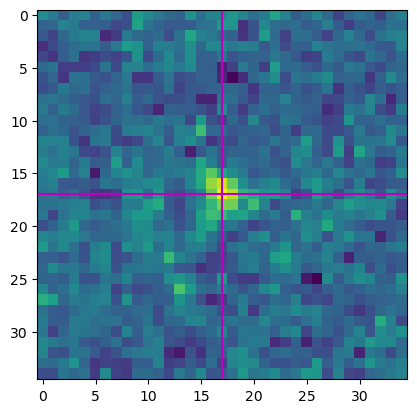

In [15]:
plt.imshow(this_box)
plt.axvline(np.floor(box_size/2), ls='-', color='m')
plt.axhline(np.floor(box_size/2), ls='-', color='m')
this_box.shape

In [17]:
class BoxCutter:
    def __init__(self, config_file, image_file=None, box_size=None, x=None, y=None):
        '''
        Busted cookie-cutter
        '''
        self.config_file = config_file
        self.image_file = image_file
        self.x = x
        self.y = y
        self.image = []
        self.error = []
        
        self.config = read_yaml(self.config_file)
        
        # We refer to box size a lot so read it in, w/e
        self.box_size = self.config['box_size']
        
    
    def _grab_box(self, x, y):
        '''
        WHAT'S IN THE BAAAHHX:
            im: should be array-like format
            x, y: location of star from catalog
            box_size: vignet size to cut around star
        Returns:
            WHAT'S IN THE BAAAAHX
        '''
        
        bb = self.box_size/2
        im = self.image
        j1 = int(np.floor(x-bb))
        j2 = int(np.floor(x+bb))
        k1 = int(np.floor(y-bb))
        k2 = int(np.floor(y+bb))
        # print(j1, j2, k1, k2)
        #this_box = im[k1:k2, j1:j2]
        return im[k1:k2, j1:j2]
        
        
    def grab_boxes(self, image_file, cat_name):
        '''
        Load image files, call box grabber
        '''
        config = self.config
        cat_hdu = config['input_catalog']['hdu']
        x_tag = config['input_catalog']['x_tag']
        y_tag = config['input_catalog']['y_tag']

        hdu = config['err_image']['hdu']
        box_size = config['box_size']

        # Reading in a file you just saved to disk, v. nice
        starcat = Table.read(cat_name, hdu=cat_hdu)
        # Also read in the weight itself
        self.image = fitsio.FITS(image_file, 'r')[hdu]
        # Grab the box. Be fancy, use maps.
        
        #ind = np.arange(len(starcat[x_tag])-1)
        x = starcat[x_tag]#[0:ind]; 
        y = starcat[y_tag]#[0:ind]
        new_boxes = list(map(self._grab_box,x,y))
                
        return new_boxes
        
        
grab = BoxCutter(config_file = 'src/cookie_cutter.yaml', image_file=im_name)

In [18]:
config = grab.config
cat_hdu = config['input_catalog']['hdu']
x_tag = config['input_catalog']['x_tag']
y_tag = config['input_catalog']['y_tag']

hdu = config['err_image']['hdu']
box_size = config['box_size']


In [19]:
ll = grab.grab_boxes(imfile, catalog)
len(ll)


896

In [239]:
type(imfile) is str

True

In [228]:
starcat

NUMBER,ALPHAWIN_J2000,DELTAWIN_J2000,X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,MAG_ISO,MAGERR_ISO,MAG_ISOCOR,MAGERR_ISOCOR,MAG_APER,MAGERR_APER,MAG_AUTO,MAGERR_AUTO,MAG_BEST,MAGERR_BEST,FLUX_AUTO,FLUXERR_AUTO,FLUX_BEST,FLUXERR_BEST,FLUX_ISO,FLUXERR_ISO,KRON_RADIUS,BACKGROUND,THRESHOLD,FLUX_MAX,ISOAREA_IMAGE,X2_IMAGE,Y2_IMAGE,XY_IMAGE,YMIN_IMAGE,YMAX_IMAGE,XMIN_IMAGE,XMAX_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,MU_THRESHOLD,MU_MAX,ISOAREA_WORLD,X_WORLD,Y_WORLD,A_WORLD,B_WORLD,THETA_WORLD,FLAGS,FWHM_IMAGE,FWHM_WORLD,ELONGATION,CLASS_STAR,FLUX_RADIUS,FLUX_APER,ELLIPTICITY,VIGNET,SNR_WIN,['err_cutout']
,deg,deg,pix,pix,pix,pix,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,ct,ct,ct,ct,ct,ct,,ct,ct,ct,pix2,pix2,pix2,pix2,pix,pix,pix,pix,pix,pix,deg,mag / arcsec2,mag / arcsec2,deg2,deg,deg,deg,deg,deg,,pix,deg,,,pix,ct,,ct,,
int32,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,"float32[35,35]",float32,"float32[45,45]"
2,149.9607293,2.2643988,10216.0752,9252.7891,10216.0166,9252.5881,27.4402,0.0574,27.1841,0.1134,27.2985,2.9431,26.8855,0.1268,26.8855,0.1268,3.022787,0.3528211,3.022787,0.3528211,1.813573,0.09592197,4.90,0.0005911407,0.09389117,0.4504485,8,5.5157561022e-01,5.0858545957e-01,1.1052449299e-01,9252,9254,10215,10217,0.802,0.646,39.50,23.1128,21.3380,5.555484e-10,1.4996072882e+02,2.2644004756e+00,6.680523e-06,5.384415e-06,-39.49,0,1.93,1.61194e-05,1.241,0.873,1.392,2.066447,0.194,0.00104458 .. 0.02361595,19.59,0.0 .. -0.0035299624
40,149.9639599,2.2722621,9828.5430,10196.3613,9828.5539,10196.1468,27.0268,0.0487,26.6667,0.1047,27.0270,0.4109,26.7686,0.0598,26.7686,0.0598,3.366312,0.1854864,3.366312,0.1854864,2.653944,0.1191164,3.50,-0.001934399,0.09406628,0.3887281,13,9.1332929259e-01,9.7129204126e-01,-2.5390458925e-01,10195,10198,9827,9830,1.094,0.829,-48.26,23.0346,21.4980,9.027661e-10,1.4996395995e+02,2.2722638782e+00,9.120526e-06,6.905858e-06,48.26,0,3.50,2.914564e-05,1.321,0.029,1.551,2.653394,0.243,-0.009016152 .. 0.03436942,23.54,-0.05497395 .. -0.022004446
42,149.9642056,2.2722668,9798.9385,10196.6699,9799.0928,10196.7045,26.4443,0.0294,26.3107,0.0523,26.2672,0.2028,26.2856,0.0379,26.2856,0.0379,5.25255,0.1834474,5.25255,0.1834474,4.538336,0.1229201,3.28,-0.003163684,0.09178109,1.066976,12,8.9708677055e-01,7.3566212013e-01,1.1606112128e-01,10195,10198,9797,9801,0.979,0.822,27.59,23.0350,20.4017,8.333226e-10,1.4996420685e+02,2.2722664767e+00,8.155258e-06,6.846576e-06,-27.59,0,1.97,1.642976e-05,1.191,0.977,1.182,5.342174,0.160,-0.04855337 .. 0.01131811,46.89,-0.026871732 .. 0.024633981
47,149.9601886,2.2726592,10280.7148,10243.9561,10280.7430,10243.8488,27.7656,0.0742,27.4009,0.1506,26.2918,0.2068,27.2689,0.0824,27.2689,0.0824,2.123557,0.1612168,2.123557,0.1612168,1.343871,0.09183239,3.85,0.001403041,0.09587825,0.295217,6,4.2510122961e-01,5.3723348440e-01,7.2658475086e-03,10243,10245,10280,10282,0.733,0.652,86.31,23.0605,21.7968,4.166611e-10,1.4996018887e+02,2.2726600999e+00,6.110653e-06,5.43027e-06,-86.30,0,2.45,2.039504e-05,1.125,0.308,1.297,5.222415,0.111,0.01452808 .. -0.05605007,16.74,0.0031580944 .. -0.046436552
56,149.9586681,2.2731083,10463.0205,10297.7432,10463.0560,10297.7601,25.3568,0.0141,25.2830,0.0228,25.3117,0.0833,25.3779,0.0138,25.3779,0.0138,12.11863,0.1542009,12.11863,0.1542009,12.35611,0.1602457,2.59,0.001925685,0.09161065,2.743848,25,1.0753067415e+00,1.2965731321e+00,3.2070506317e-03,10295,10301,10461,10465,1.139,1.037,89.17,23.1135,19.3762,1.736087e-09,1.4995866843e+02,2.2731081599e+00,9.48905e-06,8.641156e-06,-89.16,0,1.66,1.384891e-05,1.098,0.977,1.139,12.87983,0.089,-0.005687732 .. -0.01096414,122.2,0.022122515 .. -0.006950262
57,149.9447811,2.2731686,12

In [250]:
ff = fitsio.FITS(catalog, 'rw')

In [251]:
ff[1].get_nrows()

896